# Improved Respiratory Disease Classification with Selective Augmentation
### Preprocessing → Selective Augmentation → Mel-Spectrograms → 2D CNN

This notebook implements an improved respiratory disease classification model using:
1. Audio preprocessing with selective augmentation (only on minority classes)
2. Individual librosa augmentations (time stretch, noise, pitch shift)
3. Mel-spectrogram feature extraction
4. 2D CNN architecture for better spatial feature learning
5. Addresses class imbalance by augmenting only non-COPD classes

In [1]:
# Install required packages
import sys
!{sys.executable} -m pip install librosa soundfile resampy

# Import all necessary libraries
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import os
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.0 MB/s eta 0:00:00
Libraries imported successfully!


In [2]:
import kagglehub
vbookshelf_respiratory_sound_database_path = kagglehub.dataset_download('vbookshelf/respiratory-sound-database')

print('Data source import complete.')

Using Colab cache for faster access to the 'respiratory-sound-database' dataset.
Data source import complete.


## 1. Dataset Loading and Class Distribution Analysis

In [3]:
# Dataset paths - adjust these according to your setup
AUDIO_PATH = "/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/"
DIAGNOSIS_PATH = "/kaggle/input/respiratory-sound-database/Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv"

# Load file paths and patient IDs
audio_files = [f for f in os.listdir(AUDIO_PATH) if f.endswith('.wav')]
patient_ids = [int(f.split('_')[0]) for f in audio_files]
file_paths = [os.path.join(AUDIO_PATH, f) for f in audio_files]

# Load diagnosis data
diagnosis_df = pd.read_csv(DIAGNOSIS_PATH, header=None, names=['patient_id', 'diagnosis'])
diagnosis_dict = dict(zip(diagnosis_df['patient_id'], diagnosis_df['diagnosis']))

# Get labels for each audio file
labels = [diagnosis_dict[pid] for pid in patient_ids]

print(f"Total audio files: {len(audio_files)}")
print(f"Unique diagnoses: {set(labels)}")
print(f"\nOriginal label distribution:")
label_counts = pd.Series(labels).value_counts()
print(label_counts)

# Calculate class imbalance ratio
max_count = label_counts.max()
min_count = label_counts.min()
print(f"\nClass imbalance ratio: {max_count/min_count:.2f}:1")
print(f"Dominant class: {label_counts.index[0]} ({label_counts.iloc[0]} samples)")

# Identify minority classes (non-COPD classes)
minority_classes = [cls for cls in label_counts.index if cls != 'COPD']
print(f"\nMinority classes for selective augmentation: {minority_classes}")

Total audio files: 920
Unique diagnoses: {'Asthma', 'URTI', 'Bronchiolitis', 'Bronchiectasis', 'COPD', 'Pneumonia', 'LRTI', 'Healthy'}

Original label distribution:
COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: count, dtype: int64

Class imbalance ratio: 793.00:1
Dominant class: COPD (793 samples)

Minority classes for selective augmentation: ['Pneumonia', 'Healthy', 'URTI', 'Bronchiectasis', 'Bronchiolitis', 'LRTI', 'Asthma']


## 2. Advanced Audio Processor with Selective Augmentation

In [4]:
class SelectiveAudioProcessor:
    """Audio preprocessing with selective augmentation for minority classes"""

    def __init__(self, sample_rate=22050, duration=20.0, n_mels=128,
                 n_fft=2048, hop_length=512, target_length=432,
                 minority_classes=None):
        self.sample_rate = sample_rate
        self.duration = duration
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.target_length = target_length
        self.minority_classes = minority_classes or []

        # Augmentation parameters
        self.noise_factors = [0.005, 0.01, 0.02]  # Different noise levels
        self.time_stretch_rates = [0.8, 0.9, 1.1, 1.2]  # Different stretch rates
        self.pitch_shift_steps = [-2, -1, 1, 2]  # Different pitch shifts

    def load_audio(self, file_path, offset=0.5):
        """Load audio file with consistent parameters"""
        try:
            audio, _ = librosa.load(file_path, sr=self.sample_rate,
                                   duration=self.duration, offset=offset,
                                   res_type='kaiser_fast')
            return audio
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            return np.zeros(int(self.duration * self.sample_rate))

    def add_noise(self, audio, noise_factor=0.015):
        """Add white noise to audio"""
        noise = noise_factor * np.random.uniform() * np.amax(audio)
        return audio + noise * np.random.normal(size=audio.shape[0])

    def time_stretch(self, audio, rate=0.8):
        """Apply time stretching to audio"""
        try:
            return librosa.effects.time_stretch(audio, rate=rate)
        except:
            return audio  # Return original if stretching fails

    def pitch_shift(self, audio, n_steps=0.7):
        """Apply pitch shifting to audio"""
        try:
            return librosa.effects.pitch_shift(audio, sr=self.sample_rate, n_steps=n_steps)
        except:
            return audio  # Return original if pitch shifting fails

    def extract_mel_spectrogram(self, audio):
        """Extract mel-spectrogram maintaining 2D structure"""
        # Compute mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels,
            power=2.0
        )

        # Convert to dB scale
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # Normalize to [0, 1]
        mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)

        # Ensure consistent dimensions
        if mel_spec_norm.shape[1] < self.target_length:
            pad_width = self.target_length - mel_spec_norm.shape[1]
            mel_spec_norm = np.pad(mel_spec_norm, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)
        elif mel_spec_norm.shape[1] > self.target_length:
            mel_spec_norm = mel_spec_norm[:, :self.target_length]

        return mel_spec_norm

    def apply_individual_augmentations(self, audio, label):
        """Apply individual augmentations based on class"""
        augmented_mels = []

        # Always include original
        original_mel = self.extract_mel_spectrogram(audio)
        augmented_mels.append(original_mel)

        # Apply augmentations only to minority classes
        if label in self.minority_classes:
            # Individual noise augmentations
            for noise_factor in self.noise_factors:
                noise_audio = self.add_noise(audio, noise_factor)
                noise_mel = self.extract_mel_spectrogram(noise_audio)
                augmented_mels.append(noise_mel)

            # Individual time stretch augmentations
            for rate in self.time_stretch_rates:
                stretched_audio = self.time_stretch(audio, rate)
                if len(stretched_audio) > 0:
                    stretched_mel = self.extract_mel_spectrogram(stretched_audio)
                    augmented_mels.append(stretched_mel)

            # Individual pitch shift augmentations
            for n_steps in self.pitch_shift_steps:
                pitch_audio = self.pitch_shift(audio, n_steps)
                pitch_mel = self.extract_mel_spectrogram(pitch_audio)
                augmented_mels.append(pitch_mel)

        return augmented_mels

    def process_audio_selective(self, file_path, label):
        """Process audio file with selective augmentation"""
        try:
            audio = self.load_audio(file_path)
            augmented_mels = self.apply_individual_augmentations(audio, label)
            return augmented_mels
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            dummy_mel = np.zeros((self.n_mels, self.target_length))
            return [dummy_mel]

## 3. Feature Extraction with Selective Augmentation

In [5]:
# Initialize processor with minority classes
processor = SelectiveAudioProcessor(minority_classes=minority_classes)
print(f"Audio processor initialized with selective augmentation for: {minority_classes}")

# Extract mel-spectrograms with selective augmentation
print("\nExtracting mel-spectrograms with selective augmentation...")

all_mel_spectrograms = []
all_labels = []
augmentation_counts = Counter()

for i, (file_path, label) in enumerate(zip(file_paths, labels)):
    if i % 100 == 0:
        print(f"Processing file {i+1}/{len(file_paths)}")

    # Get augmented mel-spectrograms (more for minority classes)
    mel_spectrograms = processor.process_audio_selective(file_path, label)

    # Track augmentation counts
    augmentation_counts[label] += len(mel_spectrograms)

    # Add all versions
    for mel_spec in mel_spectrograms:
        all_mel_spectrograms.append(mel_spec)
        all_labels.append(label)

# Convert to numpy arrays
X_spectrograms = np.array(all_mel_spectrograms)
y_labels = np.array(all_labels)

print(f"\nFeature extraction completed!")
print(f"X_spectrograms shape: {X_spectrograms.shape}")
print(f"y_labels shape: {y_labels.shape}")

print(f"\nAugmented samples per class:")
for label in augmentation_counts.keys():
    print(f"{label}: {augmentation_counts[label]} samples")

print(f"\nFinal class distribution after selective augmentation:")
final_distribution = pd.Series(all_labels).value_counts()
print(final_distribution)

# Calculate new balance ratio
new_max = final_distribution.max()
new_min = final_distribution.min()
print(f"\nImproved class balance ratio: {new_max/new_min:.2f}:1 (vs original {max_count/min_count:.2f}:1)")

Audio processor initialized with selective augmentation for: ['Pneumonia', 'Healthy', 'URTI', 'Bronchiectasis', 'Bronchiolitis', 'LRTI', 'Asthma']

Extracting mel-spectrograms with selective augmentation...
Processing file 1/920
Processing file 101/920
Processing file 201/920
Processing file 301/920
Processing file 401/920
Processing file 501/920
Processing file 601/920
Processing file 701/920
Processing file 801/920
Processing file 901/920

Feature extraction completed!
X_spectrograms shape: (2317, 128, 432)
y_labels shape: (2317,)

Augmented samples per class:
COPD: 793 samples
Bronchiectasis: 192 samples
URTI: 276 samples
Pneumonia: 444 samples
Bronchiolitis: 156 samples
Healthy: 420 samples
Asthma: 12 samples
LRTI: 24 samples

Final class distribution after selective augmentation:
COPD              793
Pneumonia         444
Healthy           420
URTI              276
Bronchiectasis    192
Bronchiolitis     156
LRTI               24
Asthma             12
Name: count, dtype: int64

I

## 4. Data Preprocessing and Label Encoding

In [6]:
# Remove rare classes if they still have very few samples
print("Final class distribution:")
unique_labels, label_counts = np.unique(y_labels, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"{label}: {count}")

# Filter out classes with less than 50 samples after augmentation (optional)
min_samples_threshold = 50
rare_classes_after_aug = [label for label, count in zip(unique_labels, label_counts) if count < min_samples_threshold]

if rare_classes_after_aug:
    print(f"\nRemoving classes with < {min_samples_threshold} samples: {rare_classes_after_aug}")
    mask = ~np.isin(y_labels, rare_classes_after_aug)
    X_filtered = X_spectrograms[mask]
    y_filtered = y_labels[mask]
else:
    print(f"\nAll classes have sufficient samples (≥{min_samples_threshold})")
    X_filtered = X_spectrograms
    y_filtered = y_labels

print(f"\nFinal dataset after filtering:")
print(f"X_filtered shape: {X_filtered.shape}")
print(f"y_filtered shape: {y_filtered.shape}")

unique_labels, label_counts = np.unique(y_filtered, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"{label}: {count}")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_filtered)
y_categorical = to_categorical(y_encoded)
n_classes = len(label_encoder.classes_)

print(f"\nNumber of classes: {n_classes}")
print(f"Classes: {label_encoder.classes_}")

# Add channel dimension for 2D CNN
X_cnn = np.expand_dims(X_filtered, axis=-1)
print(f"X_cnn shape for 2D CNN: {X_cnn.shape}")

Final class distribution:
Asthma: 12
Bronchiectasis: 192
Bronchiolitis: 156
COPD: 793
Healthy: 420
LRTI: 24
Pneumonia: 444
URTI: 276

Removing classes with < 50 samples: [np.str_('Asthma'), np.str_('LRTI')]

Final dataset after filtering:
X_filtered shape: (2281, 128, 432)
y_filtered shape: (2281,)
Bronchiectasis: 192
Bronchiolitis: 156
COPD: 793
Healthy: 420
Pneumonia: 444
URTI: 276

Number of classes: 6
Classes: ['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
X_cnn shape for 2D CNN: (2281, 128, 432, 1)


## 5. Train-Test Split with Stratification

In [7]:
# Split the data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_categorical,
    test_size=0.2,
    random_state=42,
    stratify=y_categorical
)

# Further split training data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")
print(f"Test labels shape: {y_test.shape}")

# Check class distribution in splits
print(f"\nClass distribution in training set:")
train_class_dist = np.sum(y_train, axis=0)
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name}: {int(train_class_dist[i])}")

Training set shape: (1459, 128, 432, 1)
Validation set shape: (365, 128, 432, 1)
Test set shape: (457, 128, 432, 1)
Training labels shape: (1459, 6)
Validation labels shape: (365, 6)
Test labels shape: (457, 6)

Class distribution in training set:
Bronchiectasis: 122
Bronchiolitis: 100
COPD: 507
Healthy: 269
Pneumonia: 284
URTI: 177


## 6. Visualization of Selective Augmentation Results

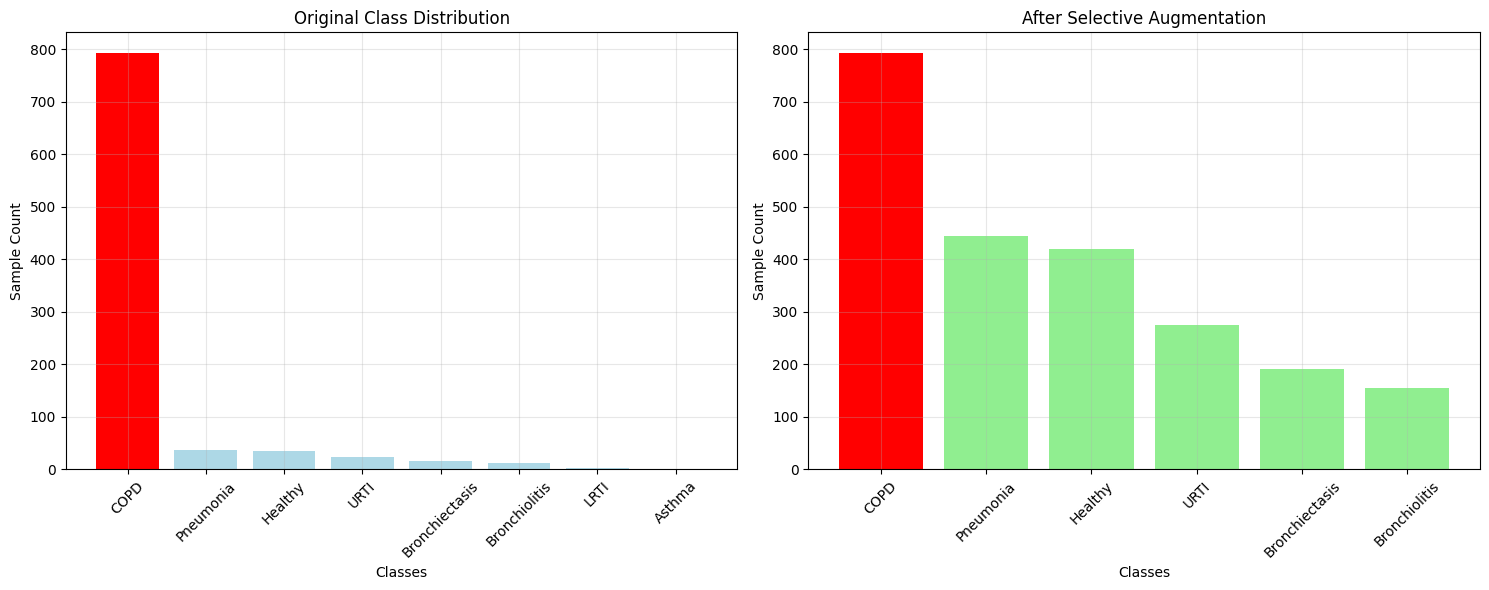


Augmentation multipliers:
COPD: 1.0x (from 793 to 793 samples)
Pneumonia: 12.0x (from 37 to 444 samples)
Healthy: 12.0x (from 35 to 420 samples)
URTI: 12.0x (from 23 to 276 samples)
Bronchiectasis: 12.0x (from 16 to 192 samples)
Bronchiolitis: 12.0x (from 13 to 156 samples)


In [8]:
# Visualize class distribution before and after selective augmentation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Original distribution
original_counts = pd.Series(labels).value_counts()
ax1.bar(range(len(original_counts)), original_counts.values,
        color=['red' if cls == 'COPD' else 'lightblue' for cls in original_counts.index])
ax1.set_title('Original Class Distribution')
ax1.set_xlabel('Classes')
ax1.set_ylabel('Sample Count')
ax1.set_xticks(range(len(original_counts)))
ax1.set_xticklabels(original_counts.index, rotation=45)
ax1.grid(True, alpha=0.3)

# After selective augmentation
final_counts = pd.Series(y_filtered).value_counts()
ax2.bar(range(len(final_counts)), final_counts.values,
        color=['red' if cls == 'COPD' else 'lightgreen' for cls in final_counts.index])
ax2.set_title('After Selective Augmentation')
ax2.set_xlabel('Classes')
ax2.set_ylabel('Sample Count')
ax2.set_xticks(range(len(final_counts)))
ax2.set_xticklabels(final_counts.index, rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show augmentation multiplier for each class
print("\nAugmentation multipliers:")
for cls in original_counts.index:
    if cls in final_counts.index:
        multiplier = final_counts[cls] / original_counts[cls]
        print(f"{cls}: {multiplier:.1f}x (from {original_counts[cls]} to {final_counts[cls]} samples)")

## 7. Visualize Sample Mel-spectrograms

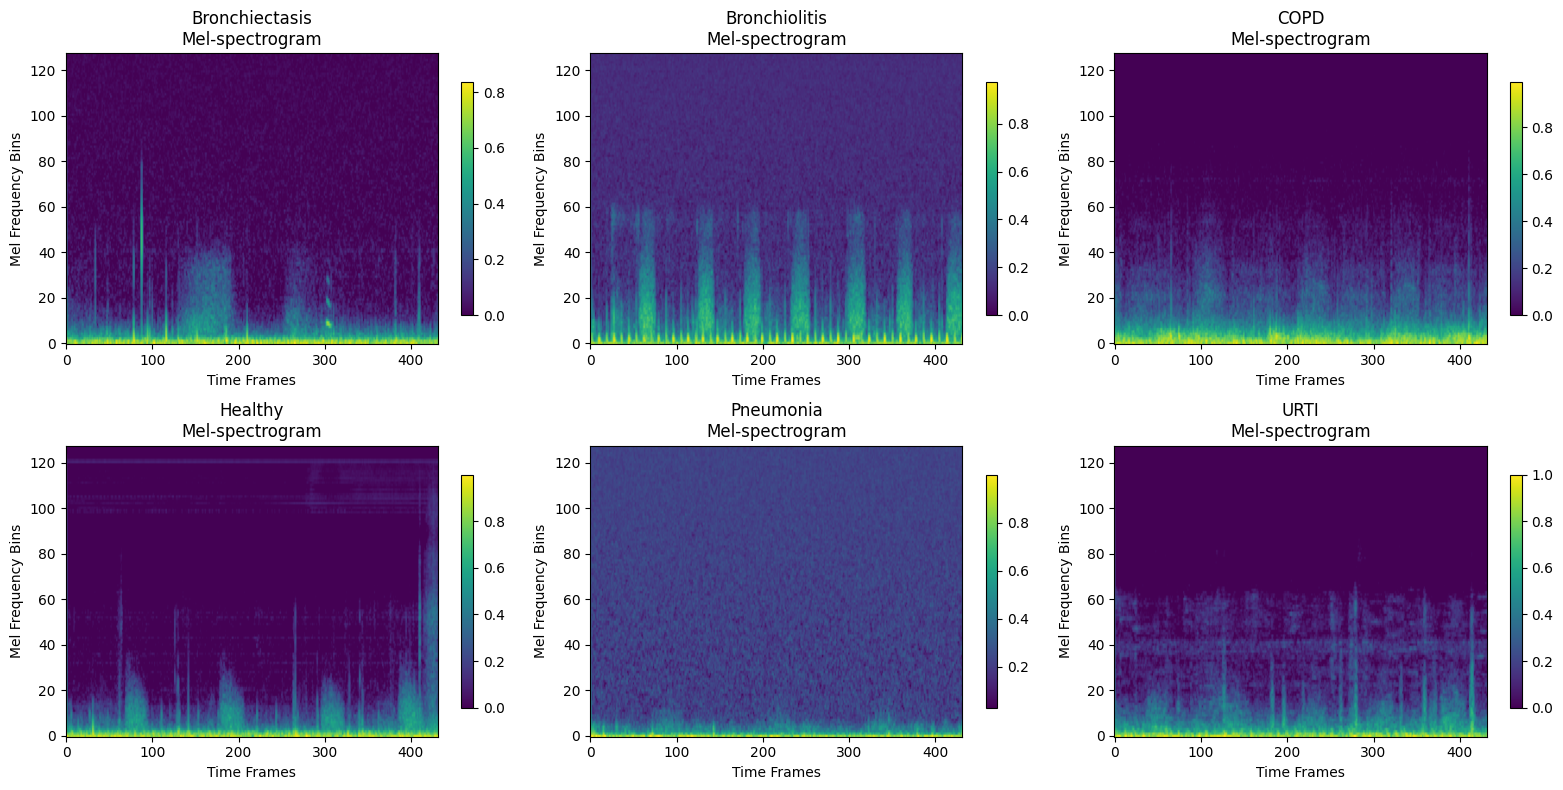

Mel-spectrogram shape: (128, 432)
Min value: 0.000, Max value: 1.000


In [9]:
# Visualize sample mel-spectrograms for each class
n_classes_viz = len(label_encoder.classes_)
fig, axes = plt.subplots(2, int(np.ceil(n_classes_viz/2)), figsize=(16, 8))
if n_classes_viz == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for i, class_name in enumerate(label_encoder.classes_):
    # Find first sample of this class
    class_indices = np.where(np.argmax(y_train, axis=1) == i)[0]
    if len(class_indices) > 0:
        sample_idx = class_indices[0]
        mel_spec = X_train[sample_idx, :, :, 0]

        im = axes[i].imshow(mel_spec, aspect='auto', origin='lower', cmap='viridis')
        axes[i].set_title(f'{class_name}\nMel-spectrogram', fontsize=12)
        axes[i].set_xlabel('Time Frames')
        axes[i].set_ylabel('Mel Frequency Bins')
        plt.colorbar(im, ax=axes[i], shrink=0.8)

# Hide empty subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

print(f"Mel-spectrogram shape: {mel_spec.shape}")
print(f"Min value: {mel_spec.min():.3f}, Max value: {mel_spec.max():.3f}")

## 8. Build Enhanced 2D CNN Model

In [10]:
def build_enhanced_2d_cnn(input_shape, n_classes):
    """Build enhanced 2D CNN model for balanced classification"""

    model = Sequential([
        # First convolutional block
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second convolutional block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Third convolutional block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Fourth convolutional block
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        GlobalAveragePooling2D(),

        # Dense layers with stronger regularization
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])

    return model

# Build the model
input_shape = X_train.shape[1:]  # (n_mels, time_frames, 1)
model_selective = build_enhanced_2d_cnn(input_shape, n_classes)

# Compile with class-aware optimization
model_selective.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("Enhanced 2D CNN Model with Selective Augmentation:")
model_selective.summary()

Enhanced 2D CNN Model with Selective Augmentation:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 432, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 432, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 432, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 216, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 216, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 216, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 216, 128)   │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 216, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 108, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 108, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 108, 256)   │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 108, 256)   │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 108, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 54, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 54, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 54, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 54, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,755,910 (10.51 MB)

 Trainable params: 2,753,990 (10.51 MB)

 Non-trainable params: 1,920 (7.50 KB)

## 9. Train the Enhanced Model

In [11]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        'best_selective_augmentation_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train the model
print("Training enhanced 2D CNN with selective augmentation...")
history_selective = model_selective.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")

Training enhanced 2D CNN with selective augmentation...
Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2899 - loss: 1.7603   
Epoch 1: val_accuracy improved from -inf to 0.19452, saving model to best_selective_augmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.2911 - loss: 1.7587 - val_accuracy: 0.1945 - val_loss: 1.8853 - learning_rate: 0.0010
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.3956 - loss: 1.5064
Epoch 2: val_accuracy did not improve from 0.19452
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 371ms/step - accuracy: 0.3965 - loss: 1.5042 - val_accuracy: 0.1945 - val_loss: 2.1608 - learning_rate: 0.0010
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5111 - loss: 1.2703
Epoch 3: val_accuracy did not improve from 0.19452
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 372ms/step - accuracy: 0.5115 - loss: 1.2684 - val_accuracy: 0.1945 - val_loss: 2.6436 - learning_rate: 0.0010
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.5328 - loss: 1.1231
Epoch 4: val_accuracy did not improve from 0.19452
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 373ms/step - accuracy: 0.5334 - loss: 1.1219 - val_accuracy: 0.1945 - val_loss: 3.4600 - learning_rate: 0.0010
Epoch 5/100
46/46 ━━

46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step - accuracy: 0.6703 - loss: 0.8288 - val_accuracy: 0.1973 - val_loss: 5.3039 - learning_rate: 0.0010
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.7089 - loss: 0.7090
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 11: val_accuracy improved from 0.19726 to 0.20274, saving model to best_selective_augmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step - accuracy: 0.7092 - loss: 0.7080 - val_accuracy: 0.2027 - val_loss: 5.5457 - learning_rate: 0.0010
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.7425 - loss: 0.6822
Epoch 12: val_accuracy improved from 0.20274 to 0.21096, saving model to best_selective_augmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 383ms/step - accuracy: 0.7428 - loss: 0.6806 - val_accuracy: 0.2110 - val_loss: 5.3415 - learning_rate: 5.0000e-04
Epoch 13/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.7607 - loss: 0.6157
Epoch 13: val_accuracy improved from 0.21096 to 0.32055, saving model to best_selective_augmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 385ms/step - accuracy: 0.7612 - loss: 0.6142 - val_accuracy: 0.3205 - val_loss: 5.8537 - learning_rate: 5.0000e-04
Epoch 14/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.7876 - loss: 0.5642
Epoch 14: val_accuracy improved from 0.32055 to 0.36712, saving model to best_selective_augmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 385ms/step - accuracy: 0.7879 - loss: 0.5632 - val_accuracy: 0.3671 - val_loss: 5.7100 - learning_rate: 5.0000e-04
Epoch 15/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.7983 - loss: 0.5035
Epoch 15: val_accuracy improved from 0.36712 to 0.47123, saving model to best_selective_augmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 385ms/step - accuracy: 0.7988 - loss: 0.5024 - val_accuracy: 0.4712 - val_loss: 2.6736 - learning_rate: 5.0000e-04
Epoch 16/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8319 - loss: 0.4794
Epoch 16: val_accuracy improved from 0.47123 to 0.52877, saving model to best_selective_augmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 386ms/step - accuracy: 0.8320 - loss: 0.4784 - val_accuracy: 0.5288 - val_loss: 1.7325 - learning_rate: 5.0000e-04
Epoch 17/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8204 - loss: 0.4459
Epoch 17: val_accuracy improved from 0.52877 to 0.66027, saving model to best_selective_augmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 386ms/step - accuracy: 0.8207 - loss: 0.4452 - val_accuracy: 0.6603 - val_loss: 1.1922 - learning_rate: 5.0000e-04
Epoch 18/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8302 - loss: 0.4592
Epoch 18: val_accuracy did not improve from 0.66027
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.8305 - loss: 0.4583 - val_accuracy: 0.5562 - val_loss: 2.1918 - learning_rate: 5.0000e-04
Epoch 19/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8488 - loss: 0.3952
Epoch 19: val_accuracy did not improve from 0.66027
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.8491 - loss: 0.3943 - val_accuracy: 0.5014 - val_loss: 2.8612 - learning_rate: 5.0000e-04
Epoch 20/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8468 - loss: 0.4162
Epoch 20: val_accuracy improved from 0.66027 to 0.68493, saving model to best_selective_augmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 389ms/step - accuracy: 0.8472 - loss: 0.4149 - val_accuracy: 0.6849 - val_loss: 1.1162 - learning_rate: 5.0000e-04
Epoch 21/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8552 - loss: 0.3959
Epoch 21: val_accuracy did not improve from 0.68493
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.8557 - loss: 0.3947 - val_accuracy: 0.6329 - val_loss: 1.2375 - learning_rate: 5.0000e-04
Epoch 22/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8694 - loss: 0.3502
Epoch 22: val_accuracy did not improve from 0.68493
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 381ms/step - accuracy: 0.8696 - loss: 0.3496 - val_accuracy: 0.6603 - val_loss: 1.3743 - learning_rate: 5.0000e-04
Epoch 23/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8735 - loss: 0.3474
Epoch 23: val_accuracy did not improve from 0.68493
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.8739 - loss: 0.3462 - val_accuracy: 0.6521 - val_loss: 1.3913 - learning_rate: 5.0000e

46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 386ms/step - accuracy: 0.8945 - loss: 0.2972 - val_accuracy: 0.8164 - val_loss: 0.5085 - learning_rate: 5.0000e-04
Epoch 25/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8946 - loss: 0.2872
Epoch 25: val_accuracy did not improve from 0.81644
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step - accuracy: 0.8946 - loss: 0.2875 - val_accuracy: 0.3233 - val_loss: 5.3064 - learning_rate: 5.0000e-04
Epoch 26/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9034 - loss: 0.2989
Epoch 26: val_accuracy did not improve from 0.81644
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9035 - loss: 0.2983 - val_accuracy: 0.7534 - val_loss: 0.5964 - learning_rate: 5.0000e-04
Epoch 27/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9113 - loss: 0.2519
Epoch 27: val_accuracy did not improve from 0.81644
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step - accuracy: 0.9115 - loss: 0.2513 - val_accuracy: 0.7589 - val_loss: 0.9621 - learning_rate: 5.0000e

46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 385ms/step - accuracy: 0.9261 - loss: 0.1941 - val_accuracy: 0.8219 - val_loss: 0.6536 - learning_rate: 5.0000e-04
Epoch 32/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9264 - loss: 0.2311
Epoch 32: val_accuracy did not improve from 0.82192
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9264 - loss: 0.2305 - val_accuracy: 0.7753 - val_loss: 0.7666 - learning_rate: 5.0000e-04
Epoch 33/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9086 - loss: 0.2325
Epoch 33: val_accuracy did not improve from 0.82192
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9088 - loss: 0.2319 - val_accuracy: 0.5507 - val_loss: 2.4249 - learning_rate: 5.0000e-04
Epoch 34/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9436 - loss: 0.1646
Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 34: val_accuracy did not improve from 0.82192
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9436 - l

46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 386ms/step - accuracy: 0.9475 - loss: 0.1532 - val_accuracy: 0.9014 - val_loss: 0.3933 - learning_rate: 2.5000e-04
Epoch 36/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9573 - loss: 0.1305
Epoch 36: val_accuracy did not improve from 0.90137
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9575 - loss: 0.1298 - val_accuracy: 0.8329 - val_loss: 0.6843 - learning_rate: 2.5000e-04
Epoch 37/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9638 - loss: 0.1145
Epoch 37: val_accuracy did not improve from 0.90137
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 381ms/step - accuracy: 0.9639 - loss: 0.1139 - val_accuracy: 0.8685 - val_loss: 0.4830 - learning_rate: 2.5000e-04
Epoch 38/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9734 - loss: 0.0807
Epoch 38: val_accuracy did not improve from 0.90137
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9734 - loss: 0.0806 - val_accuracy: 0.8247 - val_loss: 0.6875 - learning_rate: 2.5000e

46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 386ms/step - accuracy: 0.9729 - loss: 0.0863 - val_accuracy: 0.9205 - val_loss: 0.4200 - learning_rate: 2.5000e-04
Epoch 42/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9779 - loss: 0.0667
Epoch 42: val_accuracy did not improve from 0.92055
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9779 - loss: 0.0666 - val_accuracy: 0.7918 - val_loss: 0.9385 - learning_rate: 2.5000e-04
Epoch 43/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9790 - loss: 0.0755
Epoch 43: val_accuracy did not improve from 0.92055
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step - accuracy: 0.9790 - loss: 0.0753 - val_accuracy: 0.8356 - val_loss: 0.6679 - learning_rate: 2.5000e-04
Epoch 44/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9775 - loss: 0.0689
Epoch 44: val_accuracy did not improve from 0.92055
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9776 - loss: 0.0685 - val_accuracy: 0.8247 - val_loss: 0.7686 - learning_rate: 2.5000e

46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 386ms/step - accuracy: 0.9747 - loss: 0.0730 - val_accuracy: 0.9425 - val_loss: 0.2057 - learning_rate: 2.5000e-04
Epoch 46/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9910 - loss: 0.0320
Epoch 46: val_accuracy did not improve from 0.94247
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9909 - loss: 0.0319 - val_accuracy: 0.9068 - val_loss: 0.5114 - learning_rate: 2.5000e-04
Epoch 47/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9845 - loss: 0.0347
Epoch 47: val_accuracy did not improve from 0.94247
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step - accuracy: 0.9845 - loss: 0.0348 - val_accuracy: 0.8247 - val_loss: 0.8466 - learning_rate: 2.5000e-04
Epoch 48/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9870 - loss: 0.0422
Epoch 48: val_accuracy did not improve from 0.94247
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9870 - loss: 0.0422 - val_accuracy: 0.8877 - val_loss: 0.3996 - learning_rate: 2.5000e

46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 386ms/step - accuracy: 0.9853 - loss: 0.0531 - val_accuracy: 0.9479 - val_loss: 0.3507 - learning_rate: 2.5000e-04
Epoch 51/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9872 - loss: 0.0400
Epoch 51: val_accuracy improved from 0.94795 to 0.95342, saving model to best_selective_augmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 385ms/step - accuracy: 0.9872 - loss: 0.0399 - val_accuracy: 0.9534 - val_loss: 0.2529 - learning_rate: 2.5000e-04
Epoch 52/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9823 - loss: 0.0479
Epoch 52: val_accuracy did not improve from 0.95342
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9823 - loss: 0.0480 - val_accuracy: 0.8192 - val_loss: 0.8874 - learning_rate: 2.5000e-04
Epoch 53/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9729 - loss: 0.0880
Epoch 53: val_accuracy did not improve from 0.95342
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9731 - loss: 0.0877 - val_accuracy: 0.9315 - val_loss: 0.3691 - learning_rate: 2.5000e-04
Epoch 54/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9871 - loss: 0.0386
Epoch 54: val_accuracy did not improve from 0.95342
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9871 - loss: 0.0386 - val_accuracy: 0.8685 - val_loss: 0.5790 - learning_rate: 2.5000e

46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 386ms/step - accuracy: 0.9838 - loss: 0.0358 - val_accuracy: 0.9589 - val_loss: 0.1788 - learning_rate: 1.2500e-04
Epoch 57/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9955 - loss: 0.0131
Epoch 57: val_accuracy did not improve from 0.95890
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9955 - loss: 0.0131 - val_accuracy: 0.9534 - val_loss: 0.2385 - learning_rate: 1.2500e-04
Epoch 58/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9927 - loss: 0.0211
Epoch 58: val_accuracy did not improve from 0.95890
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 383ms/step - accuracy: 0.9927 - loss: 0.0211 - val_accuracy: 0.9425 - val_loss: 0.3120 - learning_rate: 1.2500e-04
Epoch 59/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9976 - loss: 0.0144
Epoch 59: val_accuracy improved from 0.95890 to 0.96712, saving model to best_selective_augmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 387ms/step - accuracy: 0.9976 - loss: 0.0143 - val_accuracy: 0.9671 - val_loss: 0.1436 - learning_rate: 1.2500e-04
Epoch 60/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9965 - loss: 0.0109
Epoch 60: val_accuracy did not improve from 0.96712
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9965 - loss: 0.0109 - val_accuracy: 0.9644 - val_loss: 0.2314 - learning_rate: 1.2500e-04
Epoch 61/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9968 - loss: 0.0118
Epoch 61: val_accuracy improved from 0.96712 to 0.98082, saving model to best_selective_augmentation_model.h5


46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 386ms/step - accuracy: 0.9968 - loss: 0.0118 - val_accuracy: 0.9808 - val_loss: 0.1134 - learning_rate: 1.2500e-04
Epoch 62/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 1.0000 - loss: 0.0069
Epoch 62: val_accuracy did not improve from 0.98082
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.9644 - val_loss: 0.1688 - learning_rate: 1.2500e-04
Epoch 63/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 1.0000 - loss: 0.0060
Epoch 63: val_accuracy did not improve from 0.98082
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 1.0000 - loss: 0.0060 - val_accuracy: 0.9808 - val_loss: 0.1481 - learning_rate: 1.2500e-04
Epoch 64/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9989 - loss: 0.0049
Epoch 64: val_accuracy did not improve from 0.98082
46/46 ━━━━━━━━━━━━━━━━━━━━ 18s 382ms/step - accuracy: 0.9989 - loss: 0.0049 - val_accuracy: 0.9699 - val_loss: 0.1752 - learning_rate: 1.2500e

## 10. Comprehensive Model Evaluation

Test Loss: 0.0640
Test Accuracy: 0.9759 (97.59%)
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step

Detailed Classification Report:
                precision    recall  f1-score   support

Bronchiectasis     1.0000    0.9487    0.9737        39
 Bronchiolitis     1.0000    0.9677    0.9836        31
          COPD     0.9755    1.0000    0.9876       159
       Healthy     0.9535    0.9762    0.9647        84
     Pneumonia     0.9886    0.9775    0.9831        89
          URTI     0.9623    0.9273    0.9444        55

      accuracy                         0.9759       457
     macro avg     0.9800    0.9662    0.9728       457
  weighted avg     0.9762    0.9759    0.9758       457


Class-wise Performance Analysis:
------------------------------------------------------------
Bronchiectasis  | Accuracy: 0.9487 | Samples:  39
Bronchiolitis   | Accuracy: 0.9677 | Samples:  31
COPD            | Accuracy: 1.0000 | Samples: 159
Healthy         | Accuracy: 0.9762 | Samples:  84
Pneumonia       | A

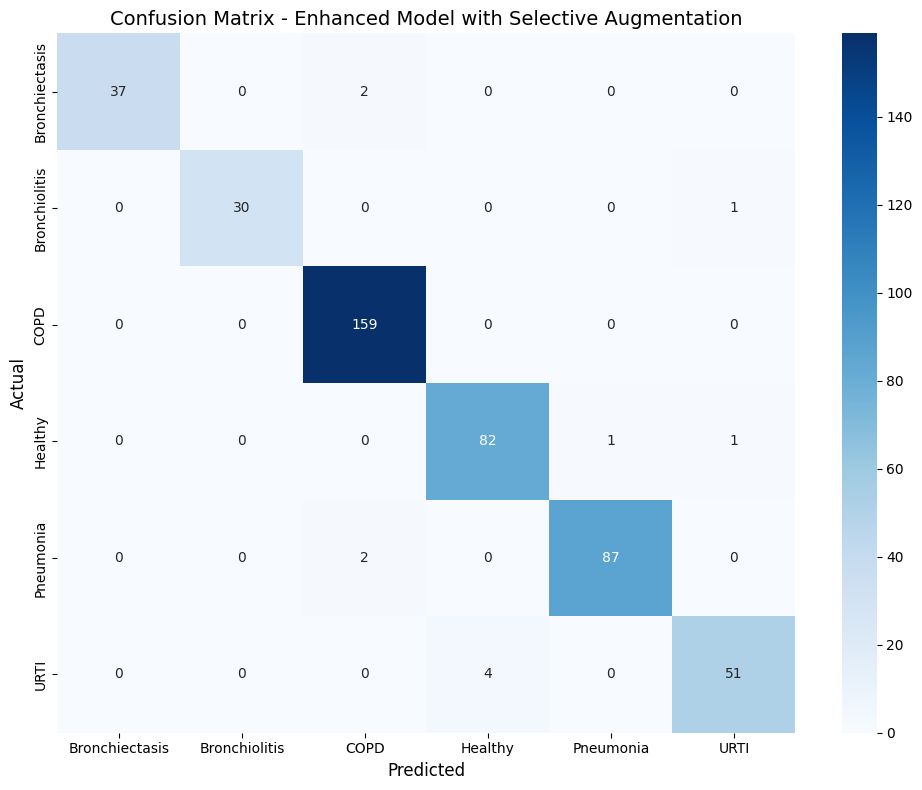


Balanced Accuracy: 0.9662 (96.62%)
Standard Accuracy: 0.9759 (97.59%)
Difference: 0.0097


In [12]:
# Evaluate on test set
test_loss, test_accuracy = model_selective.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
y_pred_proba = model_selective.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=4))

# Class-wise performance analysis
print("\nClass-wise Performance Analysis:")
print("-" * 60)
for i, class_name in enumerate(label_encoder.classes_):
    class_mask = (y_true == i)
    class_accuracy = np.mean(y_pred[class_mask] == y_true[class_mask])
    n_samples = np.sum(class_mask)
    print(f"{class_name:<15} | Accuracy: {class_accuracy:.4f} | Samples: {n_samples:>3}")

# Confusion matrix with better visualization
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Enhanced Model with Selective Augmentation', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate balanced accuracy
from sklearn.metrics import balanced_accuracy_score
balanced_acc = balanced_accuracy_score(y_true, y_pred)
print(f"\nBalanced Accuracy: {balanced_acc:.4f} ({balanced_acc*100:.2f}%)")
print(f"Standard Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Difference: {abs(balanced_acc - test_accuracy):.4f}")

## 11. Training History and Performance Visualization

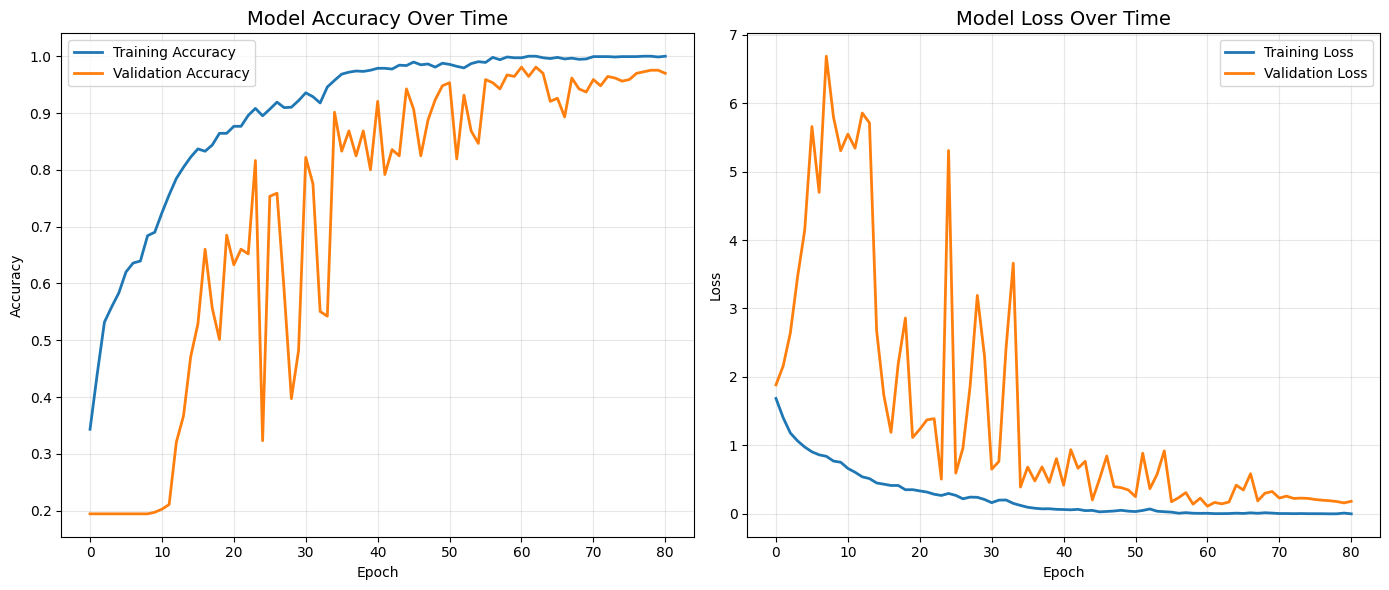


Training Summary:
Best validation accuracy: 0.9808
Final training accuracy: 1.0000
Best validation loss: 0.1134
Final test accuracy: 0.9759
Overfitting gap: 0.0241


In [13]:
# Training history visualization (only accuracy and loss)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy plot
axes[0].plot(history_selective.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history_selective.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy Over Time', fontsize=14)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss plot
axes[1].plot(history_selective.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history_selective.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss Over Time', fontsize=14)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best metrics
best_val_acc = max(history_selective.history['val_accuracy'])
best_val_loss = min(history_selective.history['val_loss'])
final_train_acc = history_selective.history['accuracy'][-1]

print(f"\nTraining Summary:")
print(f"Best validation accuracy: {best_val_acc:.4f}")
print(f"Final training accuracy: {final_train_acc:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Final test accuracy: {test_accuracy:.4f}")
print(f"Overfitting gap: {abs(final_train_acc - test_accuracy):.4f}")


In [14]:
model_selective.save("Respiratory_Sound_Classification.keras")